In [3]:
import os
import time
import pickle
import pandas as pd
import numpy as np
import datetime



import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from gensim.utils import simple_preprocess, tokenize
from gensim.summarization.textcleaner import split_sentences
from gensim.parsing import preprocessing
from gensim.models import Doc2Vec
from gensim.corpora import Dictionary


from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn import metrics # silhouette
from sklearn.preprocessing import minmax_scale

import matplotlib.pyplot as plt
from multiprocessing import cpu_count

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import ruptures as rpt
from ruptures.metrics import hausdorff, randindex

from tqdm import tqdm

# pd.set_option('display.max_colwidth',1000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

%matplotlib inline

cuda


In [4]:
df_train = pd.read_pickle('data/prod/train_samples.pkl')

In [5]:
df_train.head()

,freqs,pivots,pattern
0,"[0.8501266384547419, 0.9333112933106216, 0.968...","[11, 63]",spike_down
1,"[0.5642528003020821, 0.5783295540701987, 0.996...",[],stable
2,"[0.9017256704805636, 0.9229583934523402, 0.986...","[16, 82]",down
3,"[0.9460213693887373, 0.8285427047594923, 0.870...","[23, 57, 92]",down_up
4,"[1.0, 0.962602833443452, 0.9951430981134859, 0...","[19, 95]",down


In [6]:
def convert_pivots(df):
    # convert pivots
    
    for i, row in df.iterrows():
        if row['pattern'] == 'up_down' or row['pattern'] == 'down_up':
            row['pivots'] = np.array([row['pivots'][0], row['pivots'][2]])
        elif row['pattern'] == 'spike_up' or row['pattern'] == 'spike_down':
            temp = []
            for p in row['pivots']:
                temp.append(p-2)
                temp.append(p+2)
            row['pivots'] = np.array(temp)
            
    return df

In [7]:
# if already converted in data sampling, then no need this
df_train = convert_pivots(df_train)

In [8]:
X = np.stack(df_train['freqs'].values)
y = df_train['pivots'].values
z = df_train['pattern'].values

In [9]:
X.shape

(100000, 100)

In [10]:
X_train, X_val, y_train, y_val, z_train, z_val = train_test_split(X, y, z, test_size=5000)

In [11]:
class SeqDataset(Dataset):

    def __init__(self, X, pivots, events=None, timeline=100):
        self.X = X
        self.pivots = pivots
        self.timeline = timeline
        self.events = events

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        src = self.X[idx]
        trg = torch.zeros(self.timeline, dtype=torch.float)
        event = self.events[idx]
        
        if event == 'stable':
            is_target = torch.tensor(0, dtype=torch.float)
        else:
            is_target = torch.tensor(1, dtype=torch.float)
        
            #trg = self.format_pivots(event, self.pivots[idx])
            for i in self.pivots[idx]:
                trg[i:] = trg[i] == 0
            
        #sos = torch.tensor([1])
        #eos = torch.tensor([2])
        
        src = torch.tensor(src, dtype=torch.float)
        # src = torch.cat((sos, src, eos))
        # trg = torch.cat((sos, trg, eos))
        # add sos and eos token id
        # print(F.one_hot(trg))
        # print(self.events[idx], self.pivots[idx])
        return src, trg, is_target

        
    def format_pivots_2(self, event, pivots):
        cur = 0
        points = torch.zeros(self.timeline, dtype=torch.long)
        for p in pivots:
            if points[p] == cur:
                points[p:] = cur + 1
                cur += 1
#             else:
#                 points[p:] = 3
                
        return points
    
    def format_pivots(self, event, pivots):
        # not using anywhere but just keep here if need
        points = torch.zeros(self.timeline, dtype=torch.float)
        
        if event == 'spike_up':
            for p in pivots:
                points[p-2: p] = 1
                points[p: p+3] = 1
                
        elif event == 'spike_down':
            for p in pivots:
                points[p-2: p] = 1
                points[p: p+3] = 1
                
        elif event == 'up_down':
            points[pivots[0]: pivots[1]] = 1
            #points[pivots[1]: pivots[2]] = 1
            
        elif event == 'down_up':
            points[pivots[0]: pivots[1]] = 1
            #points[pivots[1]: pivots[2]] = 1
            
        elif event == 'up':
            points[pivots[0]: pivots[1]] = 1
            
        elif event == 'down':
            points[pivots[0]: pivots[1]] = 1
            
        else:
            pass
        
        return points


In [12]:
train_set = SeqDataset(X_train, y_train, z_train)
val_set = SeqDataset(X_val, y_val, z_val)

In [13]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=4)

In [14]:
class Seq2SeqModel(nn.Module):
    
    def __init__(self, hid_dim, out_dim, cov_dim=8, dropout=0.5, device=device):
        super(Seq2SeqModel, self).__init__()
        
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.cov_dim = cov_dim
        self.device = device
        self.embed = torch.nn.Embedding(out_dim, hid_dim)
        seq_len = 100
        
        
        # encode time series relation of input
        self.encoder = nn.LSTM(1, hid_dim, bidirectional=True, batch_first=True)  # (batch, 100, 128) + (batch, 128)

        
        self.seq_out = nn.Linear(hid_dim, out_dim)
        self.fc = nn.Linear(seq_len * hid_dim * 2, hid_dim)
        
        self.bin_out = nn.Linear(hid_dim, 1)
        self.dropout = nn.Dropout(dropout)
    

    def encode(self, X):
        X = X.unsqueeze(2)
        #print('src', src.shape)
        out, (hid, c) = self.encoder(X)  # out: batch, len, hid

        return out, hid
        
    
    def forward(self, src):
        batch_size = src.shape[0]
        trg_len = src.shape[1]
        
        
        #last hidden state of the encoder is the context
        out, hid = self.encode(src)
        #print('rnn_ctx', hidden.shape)
        rnn_out = out.reshape(batch_size, -1)
        #rnn_out = hid.reshape(batch_size, -1)
        #print('context', context.shape)
        context = self.dropout(rnn_out)
        
        fc_out = self.fc(context)
        
        seq_out = self.seq_out(F.relu(fc_out))
        bin_out = self.bin_out(F.relu(fc_out))
        
        bin_out = torch.sigmoid(bin_out)
        seq_out = torch.sigmoid(seq_out)
        
        return seq_out, bin_out


In [15]:
model = Seq2SeqModel(hid_dim=256, out_dim=100, dropout=0.5).to(device)
#model.load_state_dict(torch.load('models/rnn_cnn.pt'))
optimizer = Adam(model.parameters(), lr=1e-4)
criterion1 = nn.BCELoss()
criterion2 = nn.BCELoss()

In [16]:
def train(model, data_loader, optimizer, criterion=None):
    model.train()
    epoch_loss = 0

    for batch in data_loader:
        inputs, seq_labels, bin_labels = batch
        inputs = inputs.to(device)
        seq_labels = seq_labels.to(device)
        bin_labels = bin_labels.to(device)
        
        #print('inputs', inputs.shape)
        #print('labels', labels.shape)
        
        seq_outs, bin_outs = model(inputs)

        #print('output', outputs.shape)

        # outputs = outputs.squeeze(1)
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

        # output_dim = seq_outs.shape[-1]
        #seq_outs = seq_outs.permute(0, 2, 1)
        #seq_outs = seq_outs.reshape(-1, output_dim)
        #seq_labels = seq_labels.reshape(-1)
        bin_outs = bin_outs.squeeze(1)
        
        optimizer.zero_grad()
        loss1 = criterion1(seq_outs, seq_labels)
        loss2 = criterion2(bin_outs, bin_labels)
        
        loss = loss1 + loss2
        
        loss.backward()

        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(data_loader)

def evaluate(model, data_loader, criterion=None):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for batch in data_loader:
            inputs, seq_labels, bin_labels = batch
            inputs = inputs.to(device)
            seq_labels = seq_labels.to(device)
            bin_labels = bin_labels.to(device)

            seq_outs, bin_outs = model(inputs)
            #output_dim = seq_outs.shape[-1]
            #seq_outs = seq_outs.permute(0, 2, 1)
            #seq_outs = seq_outs.reshape(-1, output_dim)
            #seq_labels = seq_labels.reshape(-1)
            bin_outs = bin_outs.squeeze(1)
            
            loss1 = criterion1(seq_outs, seq_labels)
            loss2 = criterion2(bin_outs, bin_labels)

            loss = loss1 + loss2
            epoch_loss += loss.item()
            # y_true = torch.cat([y_true, labels])
            
#             accuracy += (preds == labels).sum()
#             n_sample += len(labels)
    
    epoch_loss = epoch_loss / len(data_loader)

    return epoch_loss

def test(model, data_loader, criterion=None):
    model.eval()
    epoch_loss = 0
    y_bin = torch.tensor([], dtype=bool).to(device)
    y_seq = torch.tensor([], dtype=bool).to(device)
    #y_true = torch.tensor([], dtype=bool).to(device)
    
    with torch.no_grad():
        for batch in data_loader:

            inputs, seq_labels, bin_labels = batch
            inputs = inputs.to(device)
            seq_labels = seq_labels.to(device)
            bin_labels = bin_labels.to(device)

            seq_outs, bin_outs = model(inputs)
            
            bin_outs = bin_outs.squeeze(1)
            bin_pred = bin_outs >= 0.5
            seq_pred = seq_outs >= 0.5

        
#             seq_pred = torch.where(seq_outs <= -0.5, torch.tensor(-1.0).to(device), seq_outs)
#             seq_pred = torch.where((seq_pred > -0.5) & (seq_pred < 0.5), torch.tensor(0.0).to(device), seq_pred)
#             seq_pred = torch.where(seq_pred >= 0.5, torch.tensor(1.0).to(device), seq_pred)
    
            # print(preds.shape)
            y_seq = torch.cat([y_seq, seq_pred])
            y_bin = torch.cat([y_bin, bin_pred])
            #y_true = torch.cat([bin_labels])
        
            #output_dim = seq_outs.shape[-1]
            #seq_outs = seq_outs.reshape(-1, output_dim)
            #seq_outs = seq_outs.permute(0, 2, 1)
            #seq_labels = seq_labels.reshape(-1)
            

            loss1 = criterion1(seq_outs, seq_labels)
            loss2 = criterion2(bin_outs, bin_labels)

            loss = loss1 + loss2
            epoch_loss += loss.item()
            # y_true = torch.cat([y_true, labels])
            
#             accuracy += (preds == labels).sum()
#             n_sample += len(labels)
    
    epoch_loss = epoch_loss / len(data_loader)
    # accuracy = accuracy.cpu().item()
    # accuracy = accuracy / n_sample
    return epoch_loss, y_bin.cpu().numpy(), y_seq.cpu().numpy()
    

In [15]:
N_EPOCH = 30   # the epoch in experiment is 30

for epoch in range(N_EPOCH):
    
    t0 = time.time()
    
    train_loss = train(model, train_loader, optimizer)
    val_loss = evaluate(model, val_loader)
    #val_loss = 0
    
    duration = (time.time() - t0) / 60
    # print(f'Train Loss: {train_loss:.4f}')
    # f1 = f1_score(y_true, y_pred)
    print(f'Epoch: {epoch+1} | Time: {duration:.2f} mins | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}')
    # print(classification_report(y_true, y_pred))

Epoch: 1 | Time: 0.99 mins | Train Loss: 0.409 | Val Loss: 0.161
Epoch: 2 | Time: 1.03 mins | Train Loss: 0.140 | Val Loss: 0.123
Epoch: 3 | Time: 1.08 mins | Train Loss: 0.115 | Val Loss: 0.102
Epoch: 4 | Time: 1.09 mins | Train Loss: 0.102 | Val Loss: 0.094
Epoch: 5 | Time: 1.12 mins | Train Loss: 0.092 | Val Loss: 0.084
Epoch: 6 | Time: 1.12 mins | Train Loss: 0.084 | Val Loss: 0.077
Epoch: 7 | Time: 1.08 mins | Train Loss: 0.077 | Val Loss: 0.070
Epoch: 8 | Time: 1.05 mins | Train Loss: 0.076 | Val Loss: 0.068
Epoch: 9 | Time: 1.05 mins | Train Loss: 0.067 | Val Loss: 0.062
Epoch: 10 | Time: 1.07 mins | Train Loss: 0.062 | Val Loss: 0.060


In [ ]:
#torch.save(model.state_dict(), 'models/rnn_cnn.pt')

In [16]:
def get_result(y_bin, y_seq):
    founds = []
    # founds = np.where(y_bin > 0)[0]
    
    for i, (x, p) in enumerate(zip(y_bin, y_seq)):
        pivots = get_pivots(p)
        if len(pivots) and x:
            founds.append(i)
    return founds


def get_pivots(pred):
    # convert sequence of 0 and 1 to list of pivots
    pivots = []

    cur = pred[0]
    for i, v in enumerate(pred):
#         if v == 1 or v == 2:
#             # print(v)
#             continue
        if v != cur:
            pivots.append(i)
            cur = v
    return pivots

def visualize_train_data(X, y, y_true=[]):
    fig, ax = plt.subplots(figsize=(20, 10))
    index = np.arange(100)
    
    ax.plot(index, X)
    ax.vlines(y, ymin=0, ymax=1, color='red')
    if len(y_true):
        ax.vlines(y_true + 0.5, ymin=0, ymax=1, color='green')
    
    ax.set(xlabel='Time', ylabel='Counts')
    # ax.legend()
    ax.set_ylim(0)
    ax.grid()
    ax.set_xticks(range(0, 100, 2))

    plt.show()

    

def get_report(y_bin, y_seq, label_points, timeline=100):
    true_bin = np.array([bool(len(p)) for p in label_points])

    print(classification_report(y_bin, true_bin, digits=4))
    randidx_pos = 0
    randidx_neg = 0
    count_neg = 0
    count_pos = 0
    
    for i, true_points in enumerate(label_points):
        true_points = np.concatenate((true_points, [timeline]), axis=0).astype(int)
        
        pred_points = get_pivots(y_seq[i])
        # print(pred_points)
        if timeline not in pred_points:
            pred_points = np.concatenate((pred_points, [timeline]), axis=0).astype(int)
            
        if len(pred_points) > 1:
            count_pos += 1
            randidx_pos += randindex(true_points, pred_points)
        else:
            count_neg += 1
            randidx_neg += randindex(true_points, pred_points)
        # print(t, p)
        # print(true_points)
        
    #print(len(true_bin), true_bin.sum(), count, randidx_neg, randidx_pos)
    print("Rand Index Positive:", randidx_pos/count_pos)
    print("Rand Index Negative:", randidx_neg/count_neg)
    
    
    
    

In [17]:
test_loss, y_bin, y_seq = test(model, val_loader)

In [18]:
get_report(y_bin, y_seq, y_val)

              precision    recall  f1-score   support

       False     1.0000    1.0000    1.0000      1997
        True     1.0000    1.0000    1.0000      3003

    accuracy                         1.0000      5000
   macro avg     1.0000    1.0000    1.0000      5000
weighted avg     1.0000    1.0000    1.0000      5000

Rand Index Positive: 0.9470766159052453
Rand Index Negative: 0.9933508068459658


In [19]:
result = get_result(y_bin, y_seq)
print(len(result))

2955


In [22]:
test_id = np.random.choice(result)
print(test_id)
print(get_pivots(y_seq[test_id]))
print(y_val[test_id])

480
[55, 80]
[53 81]


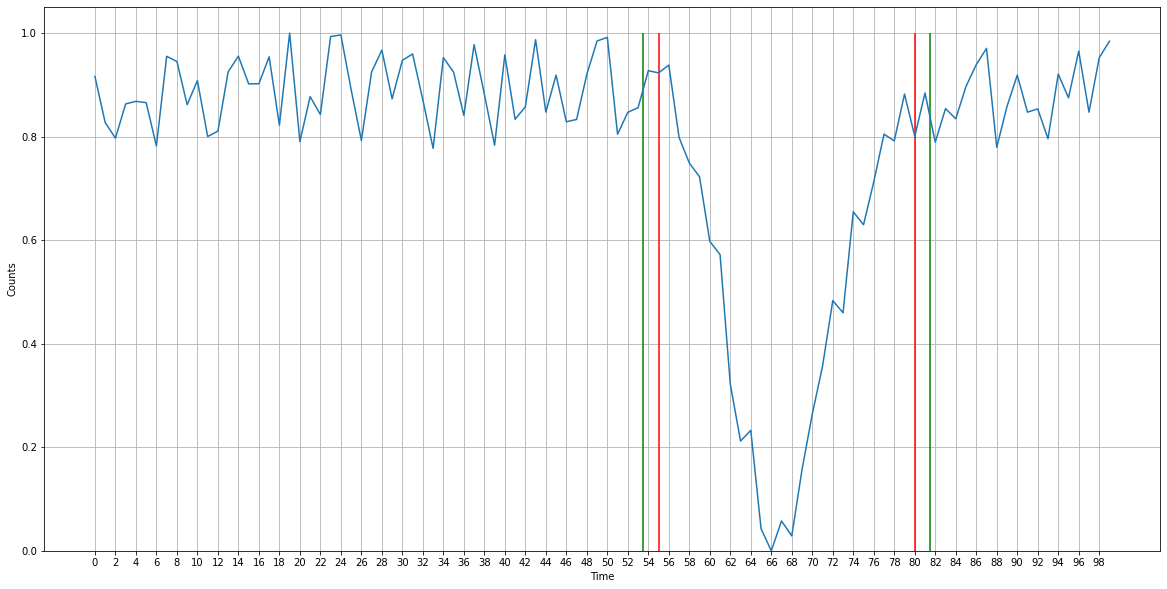

In [23]:
visualize_train_data(X_val[test_id], get_pivots(y_seq[test_id]), y_val[test_id])